# Vector Representations of Word
In this tutorial we look at the word2vec model by Mikolov et al. This model is used for learning vector representations of words, called "word embeddings".  

## Highlights
---
This tutorial is meant to highlight the interesting, substantive parts of building a word2vec model in TensorFlow.
* We start by giving the motivation for why we would want to represent words as vectors.
* We look at the intuition behind the model and how it is trained (with a splash of math for good measure).
* We also show a simple implementation of the model in TensorFlow.
* Finally, we look at ways to make the naive version scale better.  

We walk through the code later during the tutorial, but if you'd prefer to dive straight in, feel free to look at the minimalistic implementation in tensorflow/examples/tutorials/word2vec/word2vec_basic.py This basic example contains the code needed to download some data, train on it a bit and visualize the result. Once you get comfortable with reading and running the basic version, you can graduate to tensorflow_models/tutorials/embedding/word2vec.py which is a more serious implementation that showcases some more advanced TensorFlow principles about how to efficiently use threads to move data into a text model, how to checkpoint during training, etc.

But first, let's look at why we would want to learn word embeddings in the first place. Feel free to skip this section if you're an Embedding Pro and you'd just like to get your hands dirty with the details.

## Motivation: Why Learn Word Embeddings?
---
Image and audio processing systems work with rich, high-dimensional datasets encoded as vectors of the individual raw pixel-intensities for image data, or e.g. power spectral density coefficients for audio data. For tasks like object or speech recognition we know that all the information required to successfully perform the task is encoded in the data (because humans can perform these tasks from the raw data). However, natural language processing systems traditionally treat words as discrete atomic symbols, and therefore 'cat' may be represented as Id537 and 'dog' as Id143. These encodings are arbitrary, and provide no useful information to the system regarding the relationships that may exist between the individual symbols. This means that the model can leverage very little of what it has learned about 'cats' when it is processing data about 'dogs' (such that they are both animals, four-legged, pets, etc.). Representing words as unique, discrete ids furthermore leads to data sparsity, and usually means that we may need more data in order to successfully train statistical models. Using vector representations can overcome some of these obstacles. 

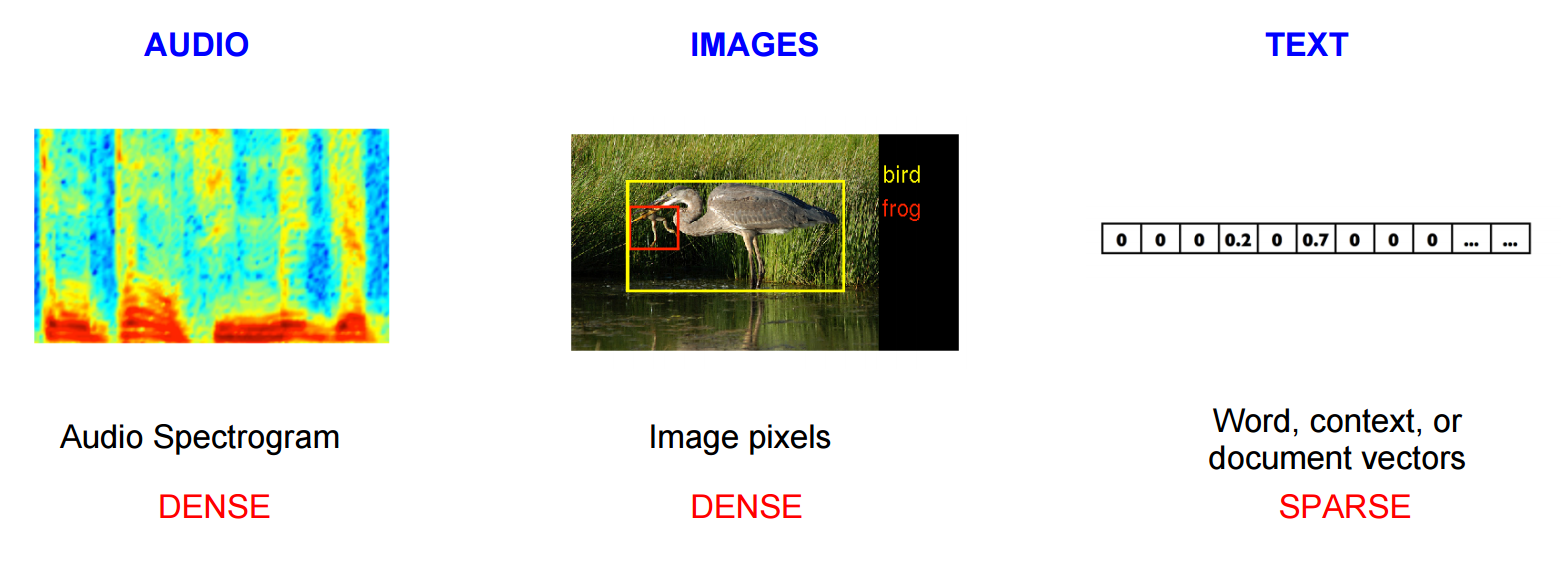

Vector space models (VSMs) represent (embed) words in a continuous vector space where semantically similar words are mapped to nearby points ('are embedded nearby each other'). VSMs have a long, rich history in NLP, but all methods depend in some way or another on the Distributional Hypothesis, which states that words that appear in the same contexts share semantic meaning. The different approaches that leverage this principle can be divided into two categories: count-based methods (e.g. Latent Semantic Analysis), and predictive methods (e.g. neural probabilistic language models).

This distinction is elaborated in much more detail by Baroni et al., but in a nutshell: Count-based methods compute the statistics of how often some word co-occurs with its neighbor words in a large text corpus, and then map these count-statistics down to a small, dense vector for each word. Predictive models directly try to predict a word from its neighbors in terms of learned small, dense embedding vectors (considered parameters of the model).

Word2vec is a particularly computationally-efficient predictive model for learning word embeddings from raw text. It comes in two flavors, the Continuous Bag-of-Words model (CBOW) and the Skip-Gram model (Section 3.1 and 3.2 in Mikolov et al.). Algorithmically, these models are similar, except that CBOW predicts target words (e.g. 'mat') from source context words ('the cat sits on the'), while the skip-gram does the inverse and predicts source context-words from the target words. This inversion might seem like an arbitrary choice, but statistically it has the effect that CBOW smoothes over a lot of the distributional information (by treating an entire context as one observation). For the most part, this turns out to be a useful thing for smaller datasets. However, skip-gram treats each context-target pair as a new observation, and this tends to do better when we have larger datasets. We will focus on the skip-gram model in the rest of this tutorial.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import math
import os
import random
import zipfile

import numpy as np
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
import tensorflow as tf

## Step 1: Download the data.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    #"""Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.request.urlretrieve(url + filename, filename)
        statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        print(statinfo.st_size)
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


## Read the data into a list of strings.

In [3]:
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data

words = read_data(filename)
print('Data size', len(words))

Data size 17005207


## Step 2: Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

In [ ]:
def build_dataset(words, vocabulary_size):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
        
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count += 1
            
        data.append(index)
        count[0][1] = unk_count
        reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys()))
        
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words, vocabulary_size)
del words  # Hint to reduce memory.
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

data_index = 0


## Step 3: Function to generate a training batch for the skip-gram model.

In [ ]:
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1  # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
        
    for i in range(batch_size // num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [skip_window]
        
    for j in range(num_skips):
        while target in targets_to_avoid:
            target = random.randint(0, span - 1)
            
        targets_to_avoid.append(target)
        batch[i * num_skips + j] = buffer[skip_window]
        labels[i * num_skips + j, 0] = buffer[target]
        
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
    # Backtrack a little bit to avoid skipping words in the end of a batch
    data_index = (data_index + len(data) - span) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

## Step 4: Build and train a skip-gram model.

In [ ]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
skip_window = 1       # How many words to consider left and right.
num_skips = 2         # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. Here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16     # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.random.choice(valid_window, valid_size, replace=False)
num_sampled = 64    # Number of negative examples to sample.

In [ ]:
graph = tf.Graph()

with graph.as_default():

    # Input data.
    train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Ops and variables pinned to the CPU because of missing GPU implementation
    with tf.device('/cpu:0'):
        # Look up embeddings for inputs.
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
        embed = tf.nn.embedding_lookup(embeddings, train_inputs)

        # Construct the variables for the NCE loss
        nce_weights = tf.Variable(
            tf.truncated_normal([vocabulary_size, embedding_size],stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Compute the average NCE loss for the batch.
    # tf.nce_loss automatically draws a new sample of the negative labels each
    # time we evaluate the loss.
    loss = tf.reduce_mean(
        tf.nn.nce_loss(weights=nce_weights,
                       biases=nce_biases,
                       labels=train_labels,
                       inputs=embed,
                       num_sampled=num_sampled,
                       num_classes=vocabulary_size))

    # Construct the SGD optimizer using a learning rate of 1.0.
    optimizer = tf.train.GradientDescentOptimizer(1.0).minimize(loss)

    # Compute the cosine similarity between minibatch examples and all embeddings.
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, normalized_embeddings, transpose_b=True)

    # Add variable initializer.
    init = tf.global_variables_initializer()

## Step 5: Begin training.

In [ ]:
num_steps = 100001

with tf.Session(graph=graph) as session:
    # We must initialize all variables before we use them.
    init.run()
    print("Initialized")

    average_loss = 0
    for step in xrange(num_steps):
        batch_inputs, batch_labels = generate_batch(batch_size, num_skips, skip_window)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 2000 == 0:
        if step > 0:
            average_loss /= 2000
        # The average loss is an estimate of the loss over the last 2000 batches.
        print("Average loss at step ", step, ": ", average_loss)
        average_loss = 0

    # Note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
        sim = similarity.eval()
        
        for i in xrange(valid_size):
            valid_word = reverse_dictionary[valid_examples[i]]
            top_k = 8  # number of nearest neighbors
            nearest = (-sim[i, :]).argsort()[1:top_k + 1]
            log_str = "Nearest to %s:" % valid_word
            
        for k in xrange(top_k):
            close_word = reverse_dictionary[nearest[k]]
            log_str = "%s %s," % (log_str, close_word)
            
        print(log_str)
        
    final_embeddings = normalized_embeddings.eval()

## Step 6: Visualize the embeddings.

In [ ]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.savefig(filename)

In [ ]:
try:
    from sklearn.manifold import TSNE
    import matplotlib.pyplot as plt

    tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
    plot_only = 500
    low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
    labels = [reverse_dictionary[i] for i in xrange(plot_only)]
    plot_with_labels(low_dim_embs, labels)

except ImportError:
    print("Please install sklearn, matplotlib, and scipy to visualize embeddings.")